<a href="https://colab.research.google.com/github/MaxCojocari/CyberPy_bot/blob/main/training/cyberbullying_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download --unzip -d andrewmvd/cyberbullying-classification

  0% 0.00/2.82M [00:00<?, ?B/s]
100% 2.82M/2.82M [00:00<00:00, 157MB/s]


In [ ]:
import torch
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from torch import nn, optim
from torchtext.vocab import GloVe
torch.manual_seed(69)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
list_stopwords = set(stopwords.words('english'))

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import re

import copy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Upload the data frame
df = pd.read_csv('cyberbullying_tweets.csv')
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

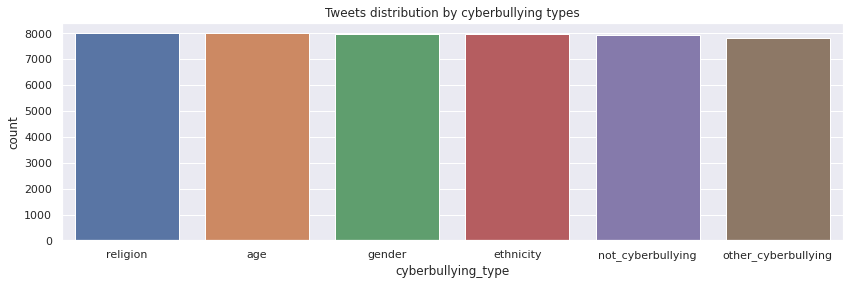

In [ ]:
sns.set(rc={'figure.figsize':(14,4)})
sns.countplot(
    x="cyberbullying_type", 
    data=df, 
    order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types"
)

From barchart is visible that our dataset is perfectly balanced.

Text(0.5, 1.0, 'Tweets distribution by cyberbullying types')

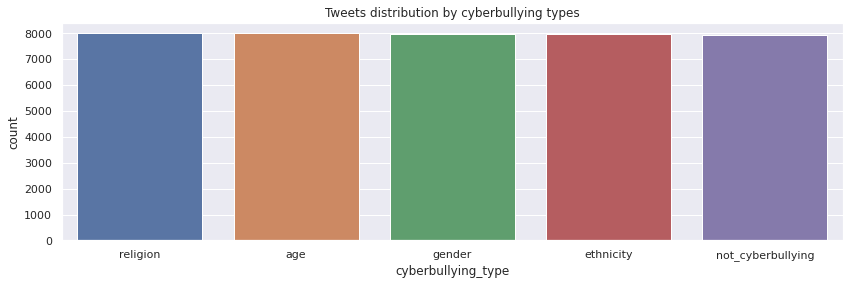

In [ ]:
df.drop(df[(df.cyberbullying_type == "other_cyberbullying")].index, inplace=True)
sns.set(rc={'figure.figsize':(14,4)})
sns.countplot(
    x="cyberbullying_type", 
    data=df, 
    order=df.cyberbullying_type.value_counts().index).set_title("Tweets distribution by cyberbullying types"
)

In [ ]:
sns.reset_orig()

In [ ]:
tokenizer = get_tokenizer('basic_english')

# to avoid removing contractions in english
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub("'", "", x))

# removing hashtags and mentions
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub("@[A-Za-z0-9_]+","", x))
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", x))

# removing url
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(r'http\S+', '', x))

# removing non-alphanumeric char
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub("[^a-zA-Z0-9]"," ", x))

# tokenize each tweet
df['tweet_text'] = df['tweet_text'].apply(tokenizer)

# remove stopwords
df['tweet_text'] = df['tweet_text'].apply(lambda x: [word for word in x if word not in list_stopwords])

In [ ]:
df

,tweet_text,cyberbullying_type
0,"[words, food, crapilicious]",not_cyberbullying
1,[white],not_cyberbullying
2,"[classy, whore, red, velvet, cupcakes]",not_cyberbullying
3,"[meh, p, thanks, heads, concerned, another, an...",not_cyberbullying
4,"[isis, account, pretending, kurdish, account, ...",not_cyberbullying
...,...,...
47687,"[black, ppl, arent, expected, anything, depend...",ethnicity
47688,"[turner, withhold, disappointment, turner, cal...",ethnicity
47689,"[swear, god, dumb, nigger, bitch, got, bleach,...",ethnicity
47690,"[yea, fuck, rt, youre, nigger, fucking, unfoll...",ethnicity


In [ ]:
# create a dict len_data with key – len of array, value – number 
# of that unique values
df["tweet_length"] = df['tweet_text'].apply(len)
len_data = {x:0 for x in df["tweet_length"].unique()}
for L in df["tweet_length"]:
    len_data[L] += 1

In [ ]:
px.histogram(
    df["tweet_length"], 
    x="tweet_length", 
    color=df["cyberbullying_type"], 
    title="Twitters Length Distribution Plot"
)

In [ ]:
# Select nonempty instances with length > 60
df.drop(df[(df.tweet_length > 45) | (df.tweet_length == 0)].index, inplace=True)
df.drop("tweet_length", axis=1, inplace=True)
df

,tweet_text,cyberbullying_type
0,"[words, food, crapilicious]",not_cyberbullying
1,[white],not_cyberbullying
2,"[classy, whore, red, velvet, cupcakes]",not_cyberbullying
3,"[meh, p, thanks, heads, concerned, another, an...",not_cyberbullying
4,"[isis, account, pretending, kurdish, account, ...",not_cyberbullying
...,...,...
47687,"[black, ppl, arent, expected, anything, depend...",ethnicity
47688,"[turner, withhold, disappointment, turner, cal...",ethnicity
47689,"[swear, god, dumb, nigger, bitch, got, bleach,...",ethnicity
47690,"[yea, fuck, rt, youre, nigger, fucking, unfoll...",ethnicity


In [ ]:
# find the length of the longest tweet
MAX_LENGTH = df['tweet_text'].apply(len).max()
MAX_LENGTH

45

In [ ]:
intent2label = {
    intent: label
    for label, intent in enumerate(df['cyberbullying_type'].unique())
}

df['label'] = df['cyberbullying_type'].apply(lambda x: intent2label[x])

In [ ]:
intent2label

{'age': 3, 'ethnicity': 4, 'gender': 1, 'not_cyberbullying': 0, 'religion': 2}

In [ ]:
df

,tweet_text,cyberbullying_type,label
0,"[words, food, crapilicious]",not_cyberbullying,0
1,[white],not_cyberbullying,0
2,"[classy, whore, red, velvet, cupcakes]",not_cyberbullying,0
3,"[meh, p, thanks, heads, concerned, another, an...",not_cyberbullying,0
4,"[isis, account, pretending, kurdish, account, ...",not_cyberbullying,0
...,...,...,...
47687,"[black, ppl, arent, expected, anything, depend...",ethnicity,4
47688,"[turner, withhold, disappointment, turner, cal...",ethnicity,4
47689,"[swear, god, dumb, nigger, bitch, got, bleach,...",ethnicity,4
47690,"[yea, fuck, rt, youre, nigger, fucking, unfoll...",ethnicity,4


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)
train_df = train_df.sort_values(by=['label'], ignore_index=True)
test_df = test_df.sort_values(by=['label'], ignore_index=True)

In [ ]:
train_df

,tweet_text,cyberbullying_type,label
0,"[rt, ethics, controllers, dogs]",not_cyberbullying,0
1,"[se, timeline, lagi, pada, nge, bully, tv, lag...",not_cyberbullying,0
2,"[isso, bullying, kkkkkkk]",not_cyberbullying,0
3,"[rt, residents, leaving, en, masse, tal, abyad...",not_cyberbullying,0
4,"[watching, devil, wears, prada, reaffirms, des...",not_cyberbullying,0
...,...,...,...
29727,"[nobody, wants, racist, fuck, dumb, nigger, ai...",ethnicity,4
29728,"[dumb, fuck, gbenga, nigger, ur, shirt, aws, n...",ethnicity,4
29729,"[dumb, nigger, would, explain, twitter, random...",ethnicity,4
29730,"[yall, hate, niggers, yet, yo, whole, family, ...",ethnicity,4


In [ ]:
glove = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 25606.56it/s]


In [ ]:
class Dataset:
    def __init__(self, df, max_length=MAX_LENGTH):
        self.df = df
        self.max_length = max_length

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        arr = self.df.loc[idx, 'tweet_text']
        arr = arr + [ '<PAD>' ] * (self.max_length - len(arr))

        return (
            glove.get_vecs_by_tokens(arr), 
            self.df.loc[idx, 'label']
        )

In [ ]:
train_dataset = Dataset(train_df)
test_dataset = Dataset(test_df)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class LSTM(nn.Module):
    #define all the layers used in model
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True, dropout=0.2):
        #Constructor
        super().__init__()          
        
        # embedding layer
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, embeds):
        
        #text = [batch size, sent_length]
        # embedded = self.embedding(text)
      
        #embedded = [batch size, sent_len, emb_dim]
        packed_output, (hidden, cell) = self.lstm(embeds)

        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2, : , : ], hidden[-1, : , : ]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)

        return dense_outputs

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
model = LSTM(50, 32, len(intent2label), 2).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Defining the function that contains the training loop
def training_loop(
    n_epochs, optimizer, model, loss_fn,
    train_loader, test_loader, device
):
    # The following torch tensor will hold information about
    # the accuracy results after every epoch
    train_accuracy = torch.zeros(n_epochs)
    test_accuracy = torch.zeros(n_epochs)

    # The actual training_loop
    for epoch in range(n_epochs):
        model.train()
        for examples, labels in train_loader:
            # Copying these tensors to the gpu ram
            # if needed
            # If a cuda compatible gpu is not available
            # the data remains on the cpu ram 
            examples = examples.to(device=device)
            labels = labels.to(device=device)

            outputs = model(examples)
            loss = loss_fn(outputs, labels)

            # Sets the gradients of all optimized torch.Tensor to zero
            optimizer.zero_grad()
            # Back Propagation
            loss.backward()
            # the optimizer updates the parameters
            optimizer.step()
        
        
        # This loop computes the accuracy for test and train data
        # after every epoch
        model.eval()
        for name, loader, accuracy in [
            ('train', train_loader, train_accuracy),
            ('test', test_loader, test_accuracy)
        ]:
            correct = 0
            total = 0

            # This with statement turns off auto grad
            with torch.no_grad():
                for examples, labels in loader:
                    examples = examples.to(device=device)
                    labels = labels.to(device=device)

                    outputs = model(examples)
                    _, predicted = torch.max(outputs, dim=1)
                    
                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
            
            accuracy[epoch] = correct / total


        # This piece of code saves the models that has the best
        # test accuracy
        best_test_accuracy = (epoch == test_accuracy.max(dim=0)[1].item())
        if best_test_accuracy:
            best_model = copy.deepcopy(model.state_dict())

        print(
            f'Epoch {epoch + 1})', 
            f'Train Accuracy: {train_accuracy[epoch]}',
            f'Test Accuracy: {test_accuracy[epoch]}',
            f'{"Best test accuracy!" if best_test_accuracy else ""}'
        )

    # Plotting the train and test accuracy after every epoch
    plt.figure(dpi=150)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy')
    plt.plot(range(1, n_epochs + 1), train_accuracy)
    plt.plot(range(1, n_epochs + 1), test_accuracy)
    plt.legend(['Train Accuracy', 'Test Accuracy'])
    plt.grid()
    plt.show()

    return best_model

Epoch 1) Train Accuracy: 0.8898829817771912 Test Accuracy: 0.8846735954284668 Best test accuracy!
Epoch 2) Train Accuracy: 0.906195342540741 Test Accuracy: 0.9006154537200928 Best test accuracy!
Epoch 3) Train Accuracy: 0.9133593440055847 Test Accuracy: 0.9036424160003662 Best test accuracy!
Epoch 4) Train Accuracy: 0.9190770983695984 Test Accuracy: 0.9094945192337036 Best test accuracy!
Epoch 5) Train Accuracy: 0.9226759076118469 Test Accuracy: 0.9104025959968567 Best test accuracy!
Epoch 6) Train Accuracy: 0.927283763885498 Test Accuracy: 0.9116133451461792 Best test accuracy!
Epoch 7) Train Accuracy: 0.9280909299850464 Test Accuracy: 0.9078801274299622 
Epoch 8) Train Accuracy: 0.9342795610427856 Test Accuracy: 0.9116133451461792 
Epoch 9) Train Accuracy: 0.9350867867469788 Test Accuracy: 0.9090909361839294 
Epoch 10) Train Accuracy: 0.9404681921005249 Test Accuracy: 0.9099990129470825 
Epoch 11) Train Accuracy: 0.9408045411109924 Test Accuracy: 0.9128241539001465 Best test accuracy

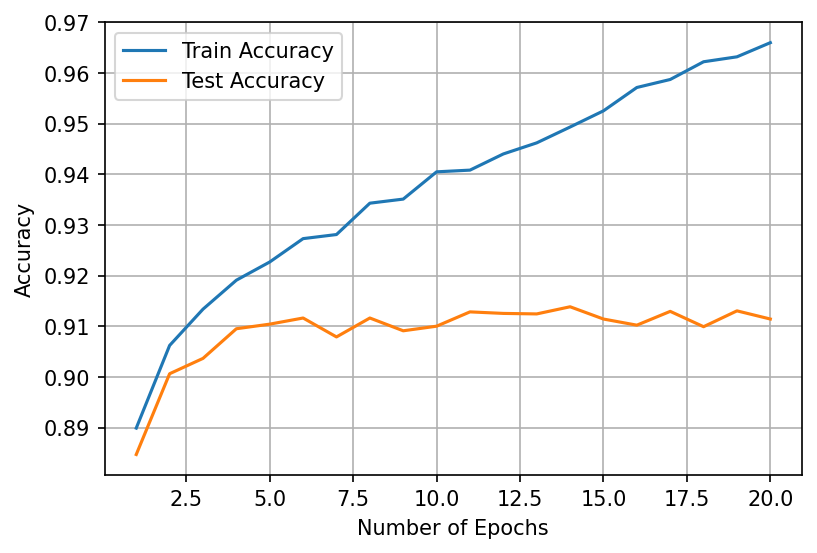

In [ ]:
best_model = training_loop(
    n_epochs=20,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)

In [ ]:
# Load the model that had the best test accuracy
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
correct = 0
total = 0

y_test = torch.zeros(len(test_df))
y_pred = torch.zeros(len(test_df))
low = 0

# Make predictions on the test data
model.eval()
with torch.no_grad():
    for examples, labels in test_loader:
        examples = examples.to(device=device)
        labels = labels.to(device=device)

        outputs = model(examples)
        _, predicted = torch.max(outputs, dim=1)

        high = low + labels.shape[0]
        y_test[low : high] = labels
        y_pred[low : high] = predicted
        low = high

        total += labels.shape[0]
        correct += int((predicted == labels).sum())
            
accuracy = correct / total
accuracy

0.913833114721017

Text(0.5, 32.08333333333333, 'Predicted Label')

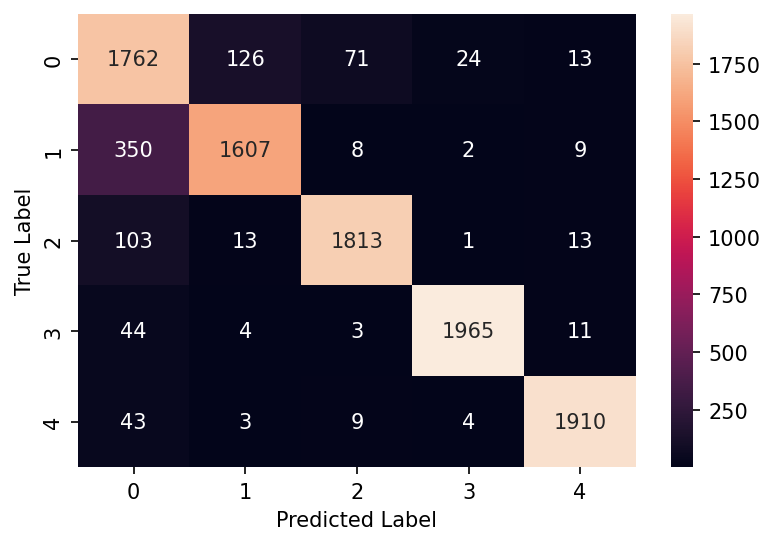

In [ ]:
# Creating a Confusion Matrix plot
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [ ]:
torch.save(best_model, 'cyberbullying_lstm.pt')

In [ ]:
%%shell
cp cyberbullying_lstm.pt drive/MyDrive/NLPC2022